In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle as pkl
import os
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:

# Charger les features extraites
with open('Images_features.pkl', 'rb') as f:
    image_features = pkl.load(f)
filenames = pkl.load(open('filenames.pkl','rb'))
df = pd.read_csv(
    '../dataset/styles.csv',
    on_bad_lines = 'skip'  
                  )

df = df.dropna()
df = pd.DataFrame(df)
# Convertir les features en array numpy
X = np.array(image_features)

# Créer un dictionnaire qui fait correspondre les IDs des images aux features
image_ids = [int(os.path.splitext(os.path.basename(f))[0]) for f in filenames]
features_dict = dict(zip(image_ids, X))

# Aligner les données avec le DataFrame
aligned_features = []
aligned_labels = []
for idx, row in df.iterrows():
    img_id = row['id']
    if img_id in features_dict:
        aligned_features.append(features_dict[img_id])
        aligned_labels.append(row['articleType'])

# Convertir en arrays numpy
X_aligned = np.array(aligned_features)
print(f"Nombre de features alignées : {len(X_aligned)}")

# Encoder les labels
le = LabelEncoder()
y_aligned = le.fit_transform(aligned_labels)
print(f"Nombre de labels alignés : {len(y_aligned)}")

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_aligned, y_aligned, test_size=0.2, random_state=42)

# Nombre de classes uniques
num_classes = len(le.classes_)
print(f"Nombre de classes : {num_classes}")

# Création du modèle de classification
def create_classifier():
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(2048,)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Initialiser le modèle
classifier = create_classifier()

# Compiler le modèle
classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner le modèle
history = classifier.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Évaluer le modèle
test_loss, test_accuracy = classifier.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Fonction pour prédire la classe d'un nouvel article
def predict_article_type(image_features, model, label_encoder):
    prediction = model.predict(np.array([image_features]))
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]
    confidence = prediction[0][predicted_class_index]
    return predicted_class, confidence

# Sauvegarder le modèle et le LabelEncoder
classifier.save('fashion_classifier.h5')
with open('label_encoder.pkl', 'wb') as f:
    pkl.dump(le, f)

Nombre de features alignées : 44072
Nombre de labels alignés : 44072
Nombre de classes : 141


Epoch 1/20


882/882 [==============================] - 37s 36ms/step - loss: 1.5998 - accuracy: 0.5878 - val_loss: 0.9401 - val_accuracy: 0.7245
Epoch 2/20
882/882 [==============================] - 30s 34ms/step - loss: 0.8659 - accuracy: 0.7461 - val_loss: 0.7750 - val_accuracy: 0.7612
Epoch 3/20
882/882 [==============================] - 31s 35ms/step - loss: 0.7161 - accuracy: 0.7789 - val_loss: 0.6759 - val_accuracy: 0.7918
Epoch 4/20
882/882 [==============================] - 27s 31ms/step - loss: 0.6414 - accuracy: 0.7992 - val_loss: 0.6222 - val_accuracy: 0.8064
Epoch 5/20
882/882 [==============================] - 25s 29ms/step - loss: 0.5772 - accuracy: 0.8171 - val_loss: 0.6066 - val_accuracy: 0.8147
Epoch 6/20
882/882 [==============================] - 30s 34ms/step - loss: 0.5350 - accuracy: 0.8266 - val_loss: 0.5808 - val_accuracy: 0.8229
Epoch 7/20
882/882 [===================

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


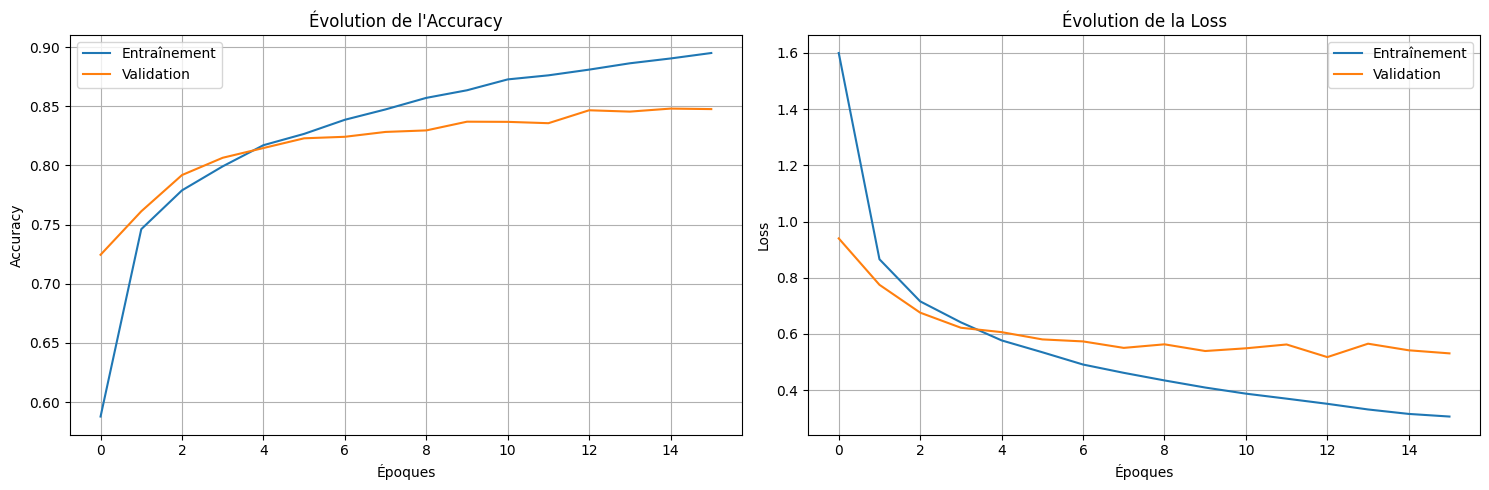

Métriques finales:
Accuracy Entraînement : 0.8949
Accuracy Validation  : 0.8476
Loss Entraînement    : 0.3063
Loss Validation      : 0.5311


In [12]:

# Création d'une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique de l'accuracy
ax1.plot(history.history['accuracy'], label='Entraînement')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Évolution de l\'Accuracy')
ax1.set_xlabel('Époques')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Graphique de la loss
ax2.plot(history.history['loss'], label='Entraînement')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Évolution de la Loss')
ax2.set_xlabel('Époques')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Ajuster la mise en page
plt.tight_layout()

# Afficher le graphique
plt.show()

# Afficher les métriques finales
print("Métriques finales:")
print(f"Accuracy Entraînement : {history.history['accuracy'][-1]:.4f}")
print(f"Accuracy Validation  : {history.history['val_accuracy'][-1]:.4f}")
print(f"Loss Entraînement    : {history.history['loss'][-1]:.4f}")
print(f"Loss Validation      : {history.history['val_loss'][-1]:.4f}")